#### TEAM MEMBERS

* Swaroop Bhandary K
* Deepansh Pandey

In [1]:
import os
import csv
import imutils
import cv2
import torch
import numpy as np
from torch import nn
from torch.optim import Adam
from torchvision import transforms
from torchvision.models import resnet18
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from collections import defaultdict
from skimage.io import imread
import matplotlib.pyplot as plt

np.random.seed(1)
torch.manual_seed(1)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(1)

In [ ]:
import xml.etree.ElementTree as ET

xml_folder_path = 'dataset/Deepansh_Swaroop/xml/'
csv_path = 'dataset/Deepansh_Swaroop/labels.csv'
img_path = 'dataset/Deepansh_Swaroop/images/'

with open(csv_path, 'w') as csvfile:
    fieldnames = ['image_name', 'part_name', 'center_x', 'center_y']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    for xml_name in os.listdir(xml_folder_path):
        xml_path = xml_folder_path + xml_name
        tree = ET.parse(xml_path)
        root = tree.getroot()

        img_name = root.find('filename').text
        objects = root.findall('object')

        for part in objects:
            name = part.find('name').text
            object_bb = part.find('bndbox')
            xmin = int(object_bb.find('xmin').text)
            xmax = int(object_bb.find('xmax').text)
            ymin = int(object_bb.find('ymin').text)
            ymax = int(object_bb.find('ymax').text)

            center_x = (xmin+xmax) // 2
            center_y = (ymin+ymax) // 2

            writer.writerow({'image_name': img_name, 'part_name': name,
                             'center_x': center_x, 'center_y': center_y})            


In [2]:
class detection_dataset(Dataset):
    def __init__(self, img_size, img_folder_path, csv_path, transform=True):
        self.height = img_size[1]
        self.width = img_size[0]
        self.folder_path = img_folder_path
        self.img_files = os.listdir(img_folder_path)
        self.csv_path = csv_path
        self.transform = transform
        self.get_annotations()
        
    def __len__(self):
        return (len(self.img_files))
    
    def __getitem__(self, index):
        img_name = self.img_files[index]
        img = imread(self.folder_path + img_name)
        annotation = self.annotations[img_name]
        annotation = annotation[:,::4,::4]
        if self.transform:
            img = img.transpose((2,0,1))
            img, annotation = torch.from_numpy(img), torch.from_numpy(annotation)
            img = img.type(torch.FloatTensor)
            img = img/255
            annotation = annotation.type(torch.FloatTensor)
        sample = {'img':img, 'annotation':annotation}

        return sample
          
    def get_annotations(self):
        self.annotations = defaultdict(lambda: np.zeros([4, self.height, self.width]))
        part_mapping = {'Head':0, 'Foot':1, 'Hand':2, 'Trunk':3}
        with open(self.csv_path) as csvfile:
            readCSV = csv.reader(csvfile)
            for row in readCSV:
                img_name = row[0]
                img_annotation = self.annotations[img_name]
                channel = part_mapping[row[1].capitalize()]
                x = int(row[3])
                y = int(row[2])
                
                if img_annotation[channel, x-8:x+8, y-8:y+8].shape != (16,16): continue
                img_annotation[channel, x-8:x+8, y-8:y+8] = makeGaussian(16,8)
                

def makeGaussian(size, fwhm = 3):
    ''' 
    Input: size: length of a side of the square
           fwhm: full-width-half-maximum (effective radius)
    Output: a square gaussian kernel
    Reference: https://stackoverflow.com/a/14525830
    '''

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    x0 = y0 = size // 2

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

In [3]:
csv_path = 'robots_dataset/deepansh_swaroop/labels.csv'
img_folder_path= 'robots_dataset/deepansh_swaroop/images/'

### Visualize the dataset

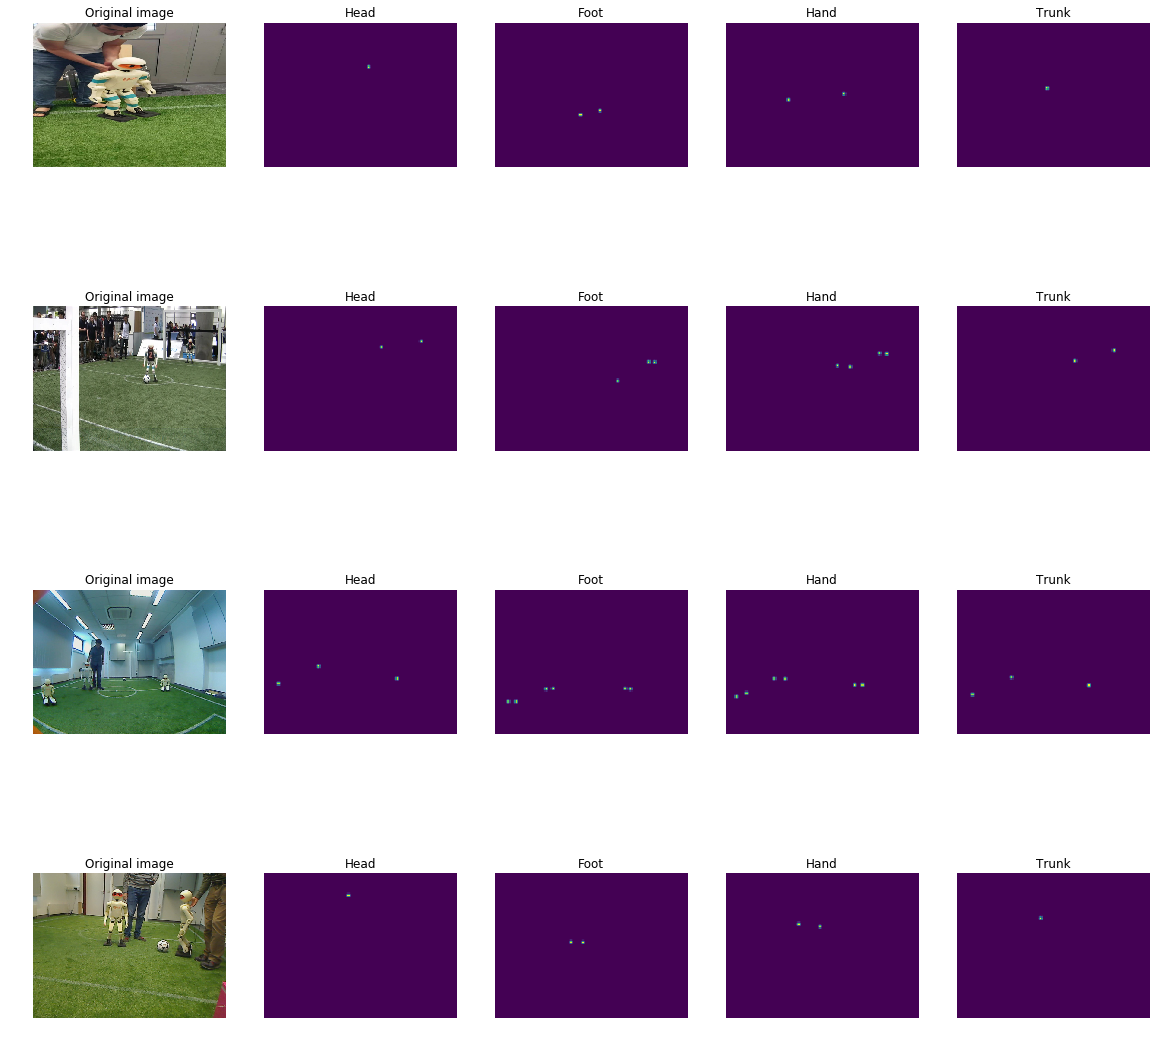

In [4]:
dg = detection_dataset((640,480), img_folder_path, csv_path)
dataloader = DataLoader(dg, batch_size=4, shuffle=True)

data = next(iter(dataloader))
imgs, annotations = data['img'], data['annotation']

plt.figure(figsize=(20,20))

_to_pil = transforms.ToPILImage()
feat_labels = ['Head', 'Foot', 'Hand', 'Trunk']

for img_idx, img in enumerate(imgs):
    annotation = annotations[img_idx]
    plt.subplot(4,5,5*img_idx+1)
    plt.axis('off')
    plt.title('Original image')
    plt.imshow(_to_pil(img))
    for feat_idx in range(4):
        plt.subplot(4,5, 5*img_idx+feat_idx+2)
        plt.axis('off')
        plt.title(feat_labels[feat_idx])
        plt.imshow(_to_pil(annotation[feat_idx,:]))
plt.show()

### Create model

In [4]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

class Model(nn.Module):
    def __init__(self, resnet):
        super(Model, self).__init__()
        self.downsampling = resnet

        self.cat1 = nn.Conv2d(64, 128, 1)
        self.cat2 = nn.Conv2d(128, 128, 1)
        self.cat3 = nn.Conv2d(256, 128, 1)
        
        self.upsampling_1 = nn.Sequential(nn.ReLU(),
                                          nn.ConvTranspose2d(512, 128, 3, 2, 1, 1)
                                         )

        self.upsampling_2 = nn.Sequential(nn.ReLU(),
                                          nn.BatchNorm2d(256),
                                          nn.ConvTranspose2d(256, 128, 3, 2, 1, 1)
                                         )

        self.upsampling_3 = nn.Sequential(nn.ReLU(),
                                          nn.BatchNorm2d(256),
                                          nn.ConvTranspose2d(256, 128, 3, 2, 1, 1)
                                         )

        self.upsampling_4 = nn.Sequential(nn.ReLU(),
                                         nn.BatchNorm2d(256),
                                         nn.ConvTranspose2d(256, 4, 3, 1, 1) 
                                        )

    def forward(self, x):
        x = self.downsampling.conv1(x)
        x = self.downsampling.bn1(x)
        x = self.downsampling.relu(x)
        x = self.downsampling.maxpool(x)

        down1 = self.downsampling.layer1(x)
        cat1 = self.cat1(down1)
        down2 = self.downsampling.layer2(down1)
        cat2 = self.cat2(down2)
        down3 = self.downsampling.layer3(down2)
        cat3 = self.cat3(down3)
        down4 = self.downsampling.layer4(down3)  

        up1 = self.upsampling_1(down4)
        up2 = self.upsampling_2(torch.cat((up1, cat3), 1))
        up3 = self.upsampling_3(torch.cat((up2, cat2), 1))
        up4 = self.upsampling_4(torch.cat((up3, cat1), 1))
        
        return up4       

In [5]:
resnet = resnet18(pretrained=True)
resnet.avgpool = Identity()
resnet.fc = Identity()

for param in resnet.parameters():
    param.requires_grad = False

model = Model(resnet)
print(model)

Model(
  (downsampling): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [ ]:
train_dg = detection_dataset((640,480), img_path, csv_path)
train_dataloader = DataLoader(dg, batch_size=20, shuffle=True)

val_dg = detection_dataset((640,480), img_path, csv_path)
val_dataloader = DataLoader(dg, batch_size=20, shuffle=True)

criterion = nn.MSELoss()
optimizer = Adam(model.parameters())
model.cuda()
criterion.cuda()

epochs = 30

losses = []
accuracies = []
fdrs = []
recalls = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for data in train_dataloader:
        img, annotation = data['image'], data['annotation']
        img, annotation = img.cuda(), annotation.cuda()   
        pred = model(img)   
        loss = criterion(pred, annotation)
        optimizer.zero_grad()
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
    
    losses.append(epoch_loss)
    
    if epoch % 5 == 0:
        model.eval()
        tp_epoch, fp_epoch, fn_epoch = 0, 0, 0
        for data in val_dataloader:
            img, annotation = data['image'], data['annotation']
            img, annotation = img.cuda(), bb.cuda()
            pred = model(img)
            tp, fp, tn, fn = detection_metrics(pred, annotation)
            tp_epoch += tp
            fp_epoch += fp
            fn_epoch += fn
        acc = (tp_epoch) / (tp_epoch + fp_epoch + fn_epoch)
        recall = tp_epoch / (tp_epoch + fn_epoch)
        # confirm the formula: false discovery rate = fp / tp + fn
        fdr = fp_epoch / (fp_epoch + tp_epoch)
        accuracies.append(acc)
        recalls.append(recall)
        fdrs.append(fdr)

### Metrics to evaluate the model

In [15]:
def detection_metrics(out, annotation):
    '''
    Returns the true positive, false positive, true negative and false negative values
    ''' 
    tp, fp, fn = 0,0,0
    
    for idx, img_out in enumerate(out):
        detected_parts = get_part_centers(img_out)
        gt_parts = get_part_centers(annotation[idx])

        for detected_part, gt_part in zip(detected_parts, gt_parts):
            for val in detected_part:
                if not val: continue
                x = val[0]
                y = val[1]
                for gt_x, gt_y in gt_part:
                    if np.abs(x-gt_x) < 4 and np.abs(y-gt_y) < 4:
                        tp += 1
                        break
                else:
                    fp += 1
                    
            for gt_x, gt_y in gt_part:
                for x,y in detected_part:
                    if np.abs(x-gt_x) < 4 and np.abs(y-gt_y) < 4:
                        break
                else:
                    fn += 1
    return tp, fp, fn

def get_part_centers(img_out):
    '''
    Decodes the network output for one image
    '''
    out = img_out.numpy()
    out = np.uint8(out * 255)
    
    detected_parts = []
    for part in out:
        blurred_part = cv2.GaussianBlur(part, (5, 5), 0)
        thresh_part = cv2.threshold(blurred_part, 60, 255, cv2.THRESH_BINARY)[1]
        cnts_part = cv2.findContours(thresh_part, cv2.RETR_EXTERNAL,
               cv2.CHAIN_APPROX_SIMPLE)
        cnts_part = imutils.grab_contours(cnts_part)

        part_loc = []
        for c in cnts_part:
            M = cv2.moments(c)
            c_x = int(M["m10"] / M["m00"]) 
            c_y = int(M["m01"] / M["m00"]) 
            part_loc.append([c_x, c_y])
        detected_parts.append(part_loc)
    return detected_parts